### Notebook for clustering 6mpi cardiac leucocytes from scratch

#### Environment: Scanpy

- **Developed by**: Alexandra Cirnu
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 240320
- **Last modified**: 240320

##### Load required modules

In [14]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

##### Load in demultiplexed & merged data set (Pkp2+Ttn)

In [3]:
adata = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/Merge_demux_QCed_ac240220.raw.h5ad')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 44594 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    layers: 'counts', 'sqrt_norm'

### Preprocessing

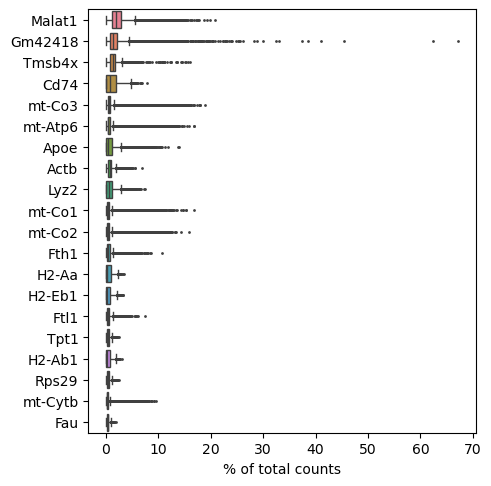

In [4]:
# show the genes that yield the highest fraction of counts across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

##### Basic filtering

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=100)

##### As QC was already performed I will directly continue with **normalization**

In [6]:
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell to be able to compare the counts among cells
sc.pp.normalize_total(adata, target_sum=1e4)

In [7]:
# Logarthmize the data
sc.pp.log1p(adata)

##### Identify Highly variable genes

/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


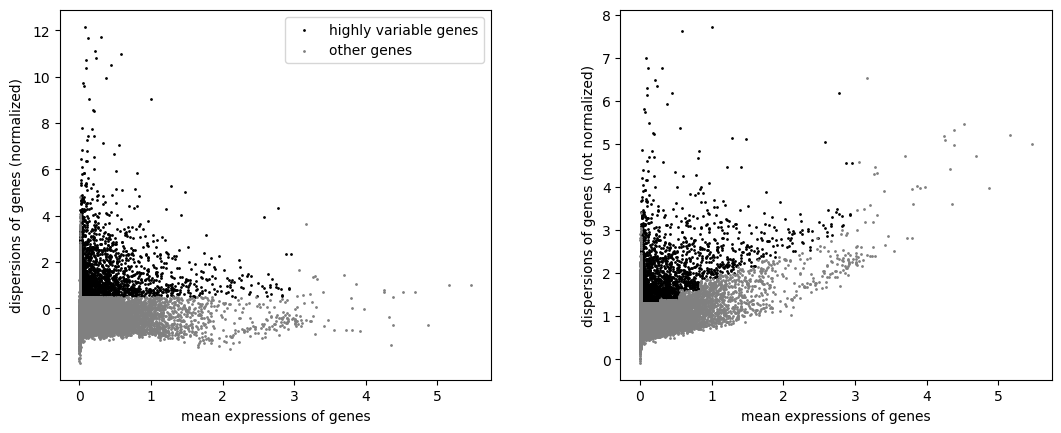

In [9]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

##### Freeze the state of the AnnData object (normalized + logarithmized) in `.raw` for later use in differential testing and gene expression visualizations

In [10]:
adata.raw = adata

### Principal Component Analysis

In [12]:
# Reduce dimensionality of the data by using PCA, which reveals the main axes of variation
sc.tl.pca(adata, svd_solver="arpack")

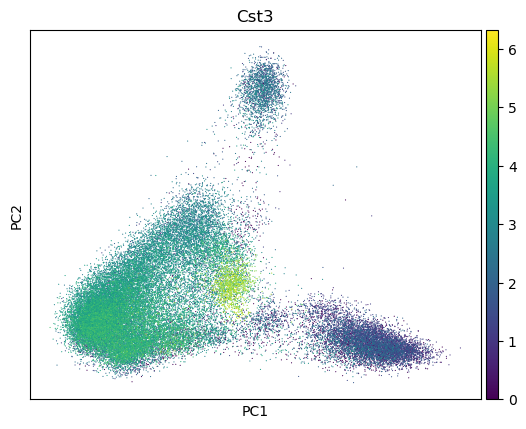

In [18]:
#Scatter plot in the PCA coordinates (not used later on)
sc.pl.pca(adata, color="Cst3")                              #Cst3 is a gene

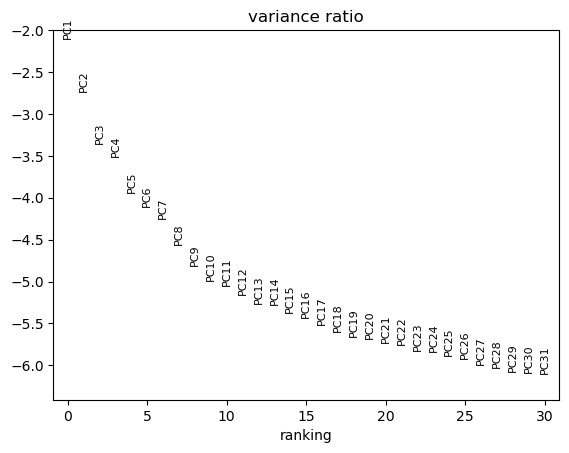

In [19]:
# Find out how many PCs contribute to most of the variance in the data in order to properly compute the neighborhood relations of cells later on
sc.pl.pca_variance_ratio(adata, log=True)

In [20]:
adata

AnnData object with n_obs × n_vars = 44594 × 15467
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersio

### Computing and Embedding the neighborhood graph

In [21]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [23]:
sc.tl.paga(adata, groups='condition')
sc.pl.paga(adata, plot=False)           # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [24]:
sc.tl.umap(adata)

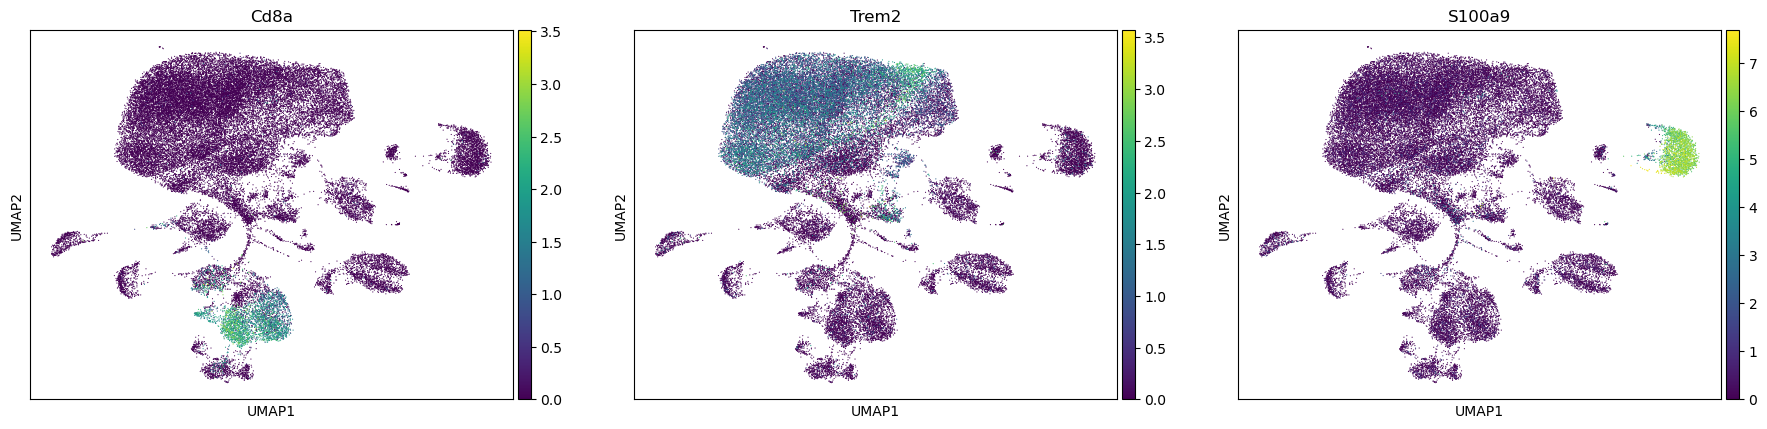

In [25]:
sc.pl.umap(adata, color=["Cd8a", "Trem2", "S100a9"])

### Clustering the neighborhood graph

In [28]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


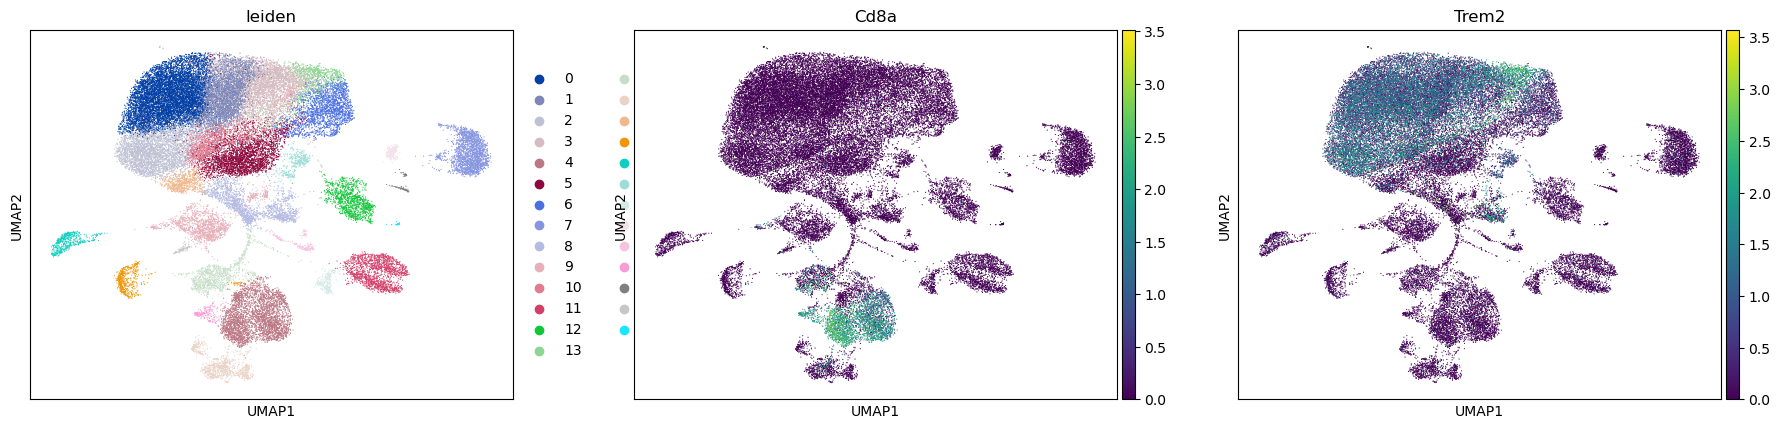

In [29]:
sc.pl.umap(adata, color=["leiden", "Cd8a", "Trem2"])

### Finding marker genes

In [32]:
sc.settings.verbosity = 2

ranking genes


/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished (0:00:44)


/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: Perf

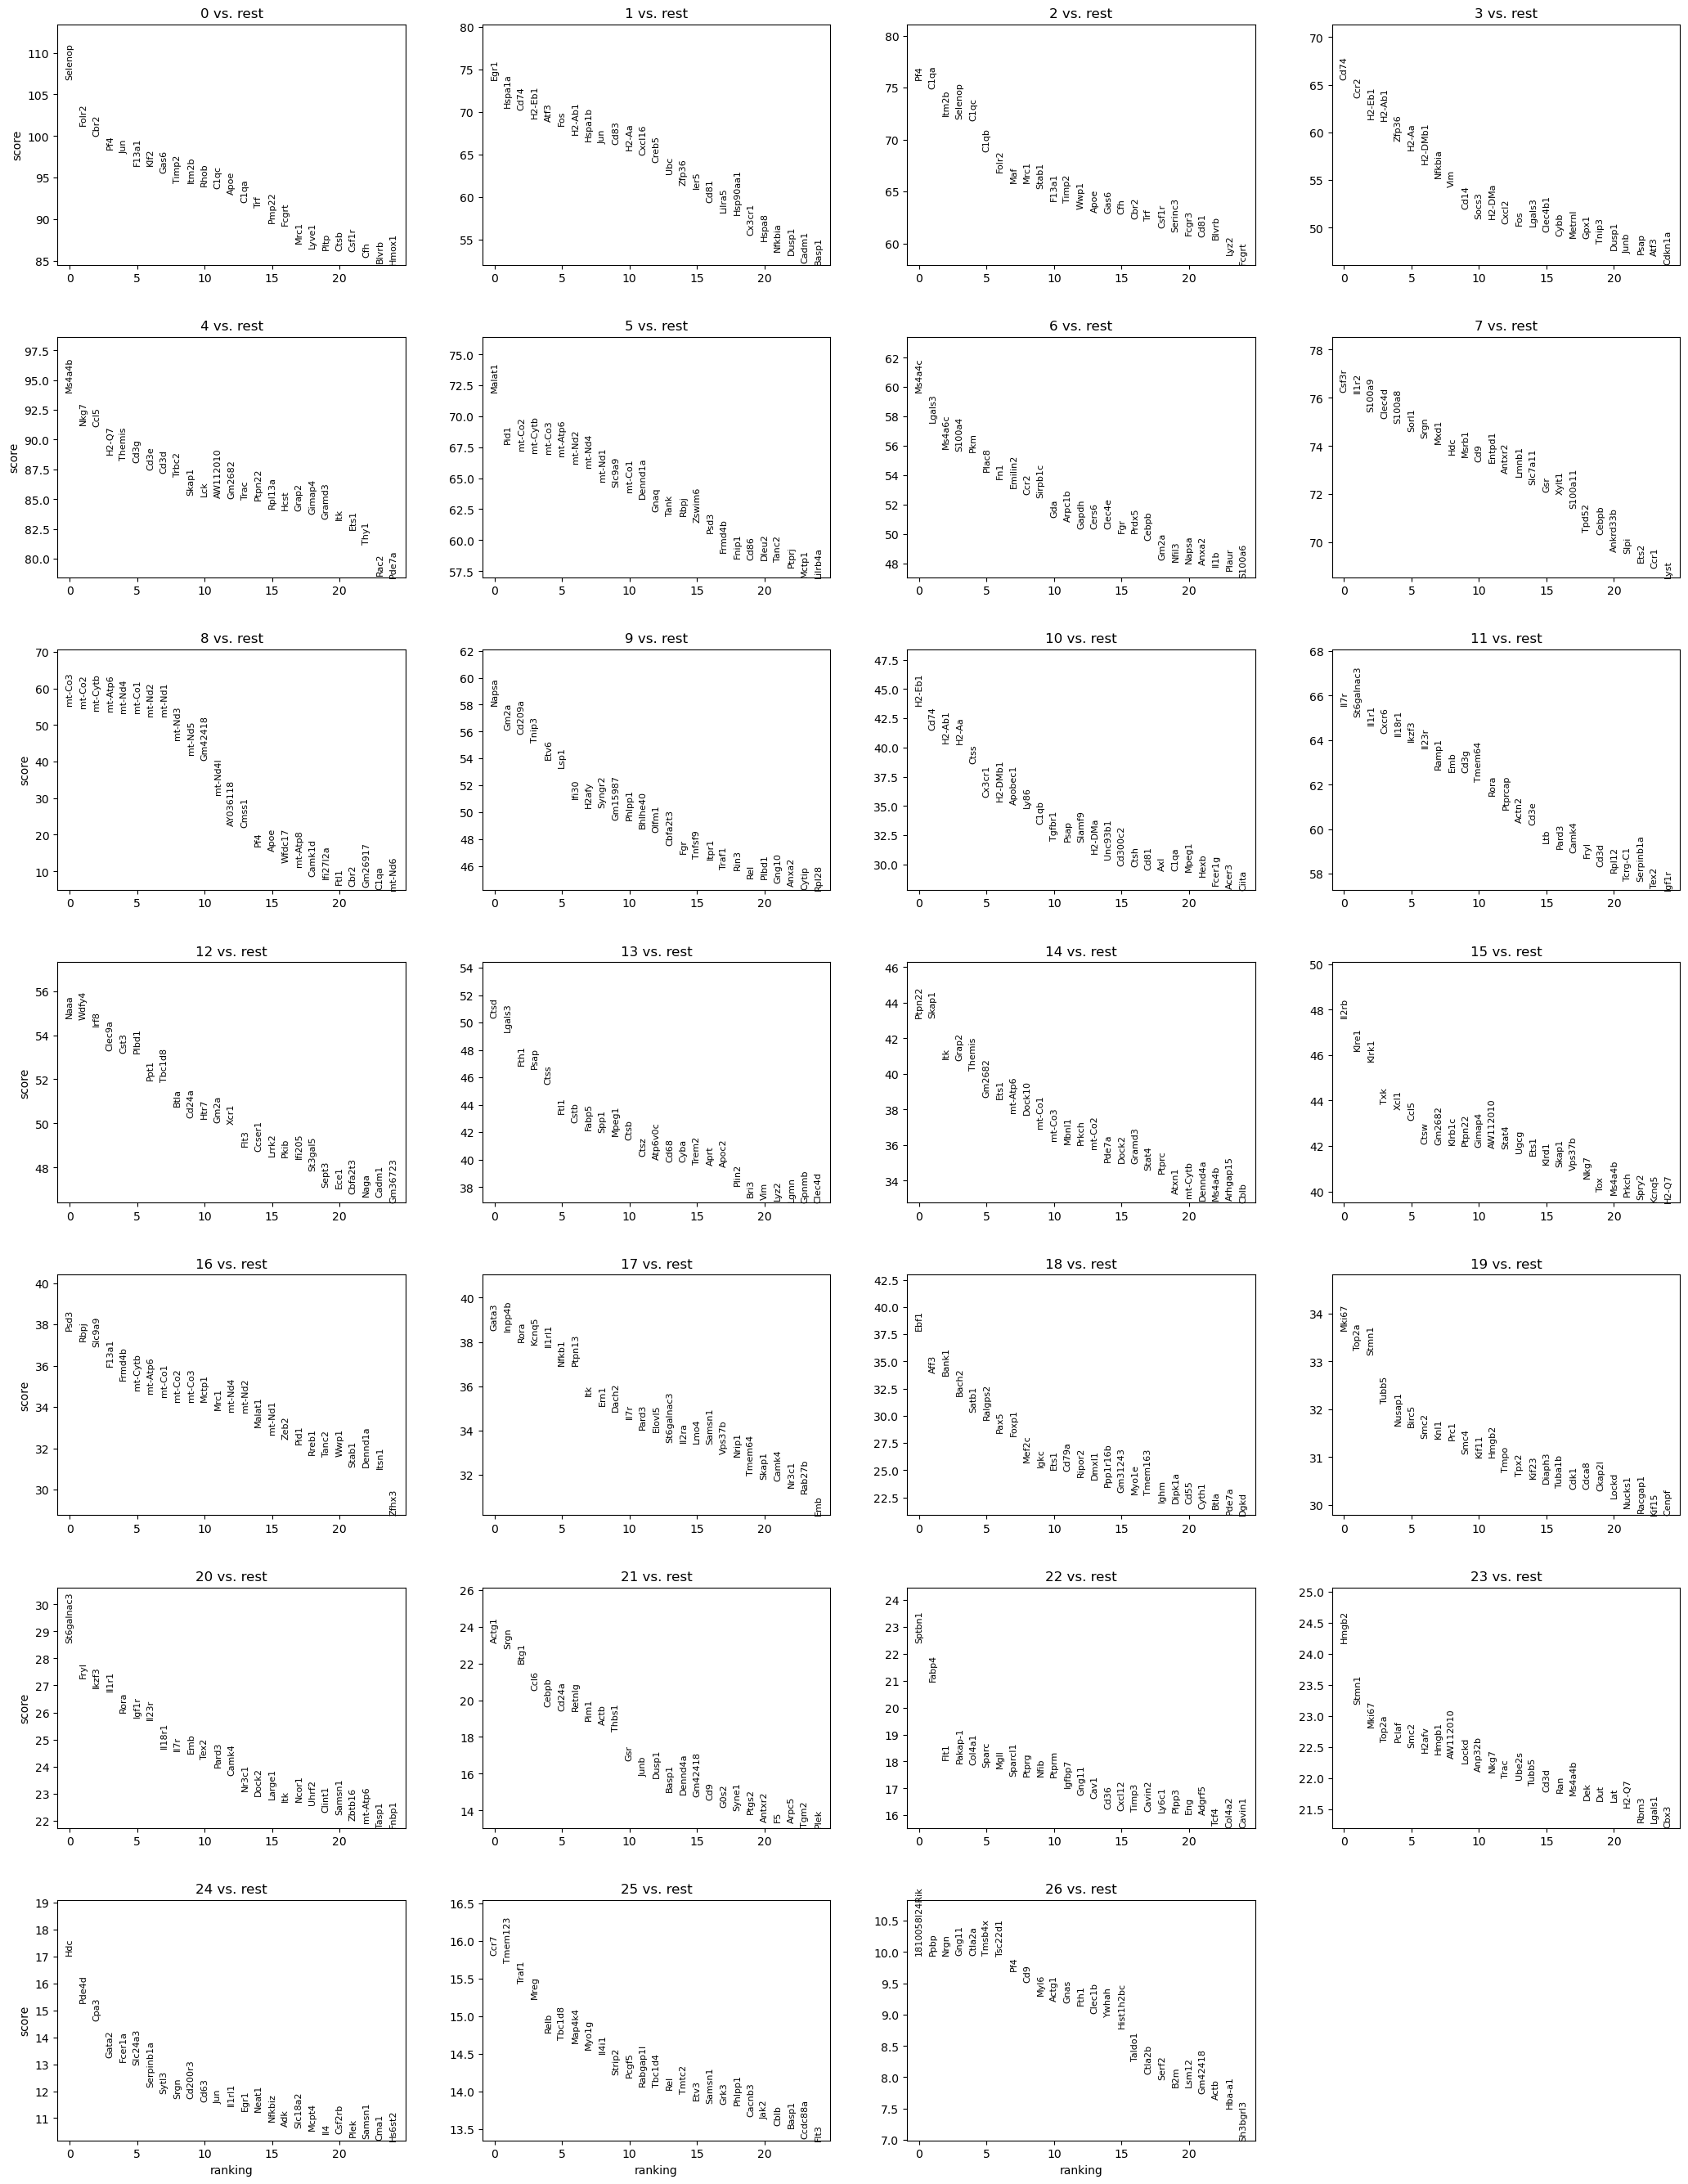

In [36]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [38]:
#Show the top 10 ranked genes per cluster
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(10)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,Selenop,Egr1,Pf4,Cd74,Ms4a4b,Malat1,Ms4a4c,Csf3r,mt-Co3,Napsa,...,Gata3,Ebf1,Mki67,St6galnac3,Actg1,Sptbn1,Hmgb2,Hdc,Ccr7,1810058I24Rik
1,Folr2,Hspa1a,C1qa,Ccr2,Nkg7,Pid1,Lgals3,Il1r2,mt-Co2,Gm2a,...,Inpp4b,Aff3,Top2a,Fryl,Srgn,Fabp4,Stmn1,Pde4d,Tmem123,Ppbp
2,Cbr2,Cd74,Itm2b,H2-Eb1,Ccl5,mt-Co2,Ms4a6c,S100a9,mt-Cytb,Cd209a,...,Rora,Bank1,Stmn1,Ikzf3,Btg1,Flt1,Mki67,Cpa3,Traf1,Nrgn
3,Pf4,H2-Eb1,Selenop,H2-Ab1,H2-Q7,mt-Cytb,S100a4,Clec4d,mt-Atp6,Tnip3,...,Kcnq5,Bach2,Tubb5,Il1r1,Ccl6,Pakap-1,Top2a,Gata2,Mreg,Gng11
4,Jun,Atf3,C1qc,Zfp36,Themis,mt-Co3,Pkm,S100a8,mt-Nd4,Etv6,...,Il1rl1,Satb1,Nusap1,Rora,Cebpb,Col4a1,Pclaf,Fcer1a,Relb,Ctla2a
5,F13a1,Fos,C1qb,H2-Aa,Cd3g,mt-Atp6,Plac8,Sorl1,mt-Co1,Lsp1,...,Nfkb1,Ralgps2,Birc5,Igf1r,Cd24a,Sparc,Smc2,Slc24a3,Tbc1d8,Tmsb4x
6,Klf2,H2-Ab1,Folr2,H2-DMb1,Cd3e,mt-Nd2,Fn1,Srgn,mt-Nd2,Ifi30,...,Ptpn13,Pax5,Smc2,Il23r,Retnlg,Mgll,H2afv,Serpinb1a,Map4k4,Tsc22d1
7,Gas6,Hspa1b,Maf,Nfkbia,Cd3d,mt-Nd4,Emilin2,Mxd1,mt-Nd1,H2afy,...,Itk,Foxp1,Knl1,Il18r1,Pim1,Sparcl1,Hmgb1,Sytl3,Myo1g,Pf4
8,Timp2,Jun,Mrc1,Vim,Trbc2,mt-Nd1,Ccr2,Hdc,mt-Nd3,Syngr2,...,Ern1,Mef2c,Prc1,Il7r,Actb,Ptprg,AW112010,Srgn,Il4i1,Cd9
9,Itm2b,Cd83,Stab1,Cd14,Skap1,Slc9a9,Sirpb1c,Msrb1,mt-Nd5,Gm15987,...,Dach2,Igkc,Smc4,Emb,Thbs1,Nfib,Lockd,Cd200r3,Strip2,Myl6


In [39]:
#Get a table with the scores and groups
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,22_n,22_p,23_n,23_p,24_n,24_p,25_n,25_p,26_n,26_p
0,Selenop,0.0,Egr1,0.0,Pf4,0.0,Cd74,0.0,Ms4a4b,0.0,...,Sptbn1,3.052413e-111,Hmgb2,3.613633e-129,Hdc,4.859536e-65,Ccr7,2.755138e-56,1810058I24Rik,2.628465e-23
1,Folr2,0.0,Hspa1a,0.0,C1qa,0.0,Ccr2,0.0,Nkg7,0.0,...,Fabp4,1.153093e-97,Stmn1,4.694886e-119,Pde4d,1.048563e-52,Tmem123,1.298350e-55,Ppbp,2.629179e-23
2,Cbr2,0.0,Cd74,0.0,Itm2b,0.0,H2-Eb1,0.0,Ccl5,0.0,...,Flt1,4.454646e-73,Mki67,2.279520e-115,Cpa3,2.643519e-48,Traf1,8.516265e-54,Nrgn,2.629179e-23
3,Pf4,0.0,H2-Eb1,0.0,Selenop,0.0,H2-Ab1,0.0,H2-Q7,0.0,...,Pakap-1,4.866271e-72,Top2a,4.918487e-113,Gata2,4.156807e-40,Mreg,1.949370e-52,Gng11,2.635259e-23
4,Jun,0.0,Atf3,0.0,C1qc,0.0,Zfp36,0.0,Themis,0.0,...,Col4a1,1.863950e-71,Pclaf,5.943890e-113,Fcer1a,3.209995e-39,Relb,1.646810e-49,Ctla2a,2.645663e-23


ranking genes


/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished (0:00:09)


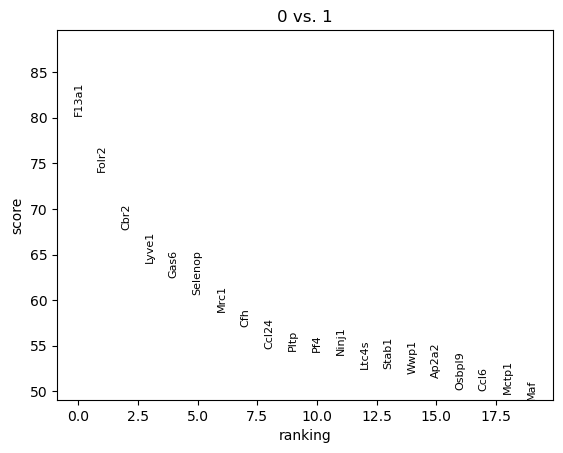

In [40]:
#Compare to a single cluster
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


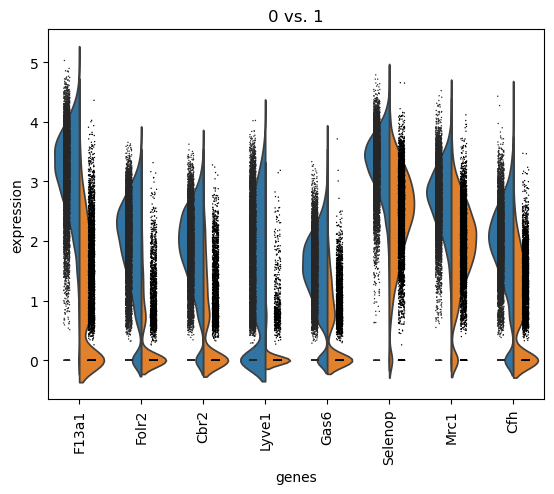

In [43]:
#More detailed view
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


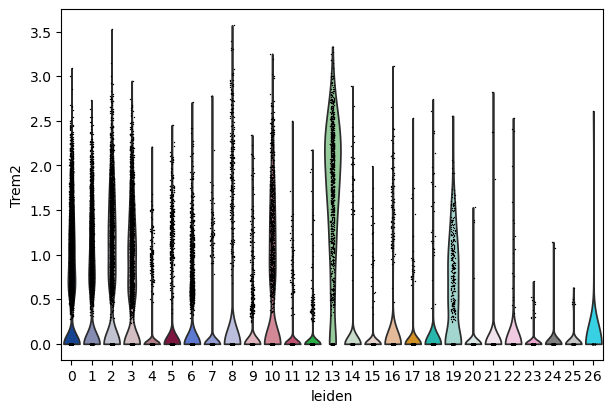

In [44]:
#Compare a gene across clusters
sc.pl.violin(adata, ["Trem2"], groupby="leiden")